In [3]:
from matplotlib.image import imread
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import pywt
import os
from PIL import Image
from skimage import color
from sklearn import svm
import pandas as pd

In [40]:
HIST_FOLDER = r'D:\GABY\UPH\TA2\Code\face-detection-result-clean-resized-gray-hist'
DWT_WITH_DCT_FOLDER = r'D:\GABY\UPH\TA2\Code\face-detection-result-clean-resized-gray-hist-dwtwithdct'
TEST_DWT_WITH_DCT_FOLDER = r'D:\GABY\UPH\TA2\Code\test-face-detection-result-clean-resized-gray-hist-dwtwithdct'
CSV_FOLDER = r'D:\GABY\UPH\TA2\Code\face-detection-result-clean-picked-id.csv'
TEST_FOLDER = r'D:\GABY\UPH\TA2\Code\test-face-detection-result-clean-resized-gray-hist'
TEST_CSV = r'D:\GABY\UPH\TA2\Code\test-face-detection-result-clean-picked-id.csv'

In [5]:
#find number of images in file
list = os.listdir(HIST_FOLDER) # dir is your directory path
number_files = len(list)

## Training Phase

### Discrete Wavelet Transform

In [6]:
#Wavelet Compression
w = 'haar'

#features array for SVM
x1 = [] #keep 90%
x2 = [] #keep 75%

for keep in (0.9, 0.75):   
    for iteration in range(number_files):
        i = iteration+1
        img = Image.open(f'{HIST_FOLDER}/{str(i)}.jpg')
        coeffs = pywt.wavedec2(img, wavelet = w, level=2) 
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs) #arrange coeffs into single array
        features = coeff_arr[coeff_slices[0]]
        
        #input DWT compressed coefficients to corresponding arrays
        if(keep == 0.9):
            x1.append(features)
            #plt.imsave(f'{DWT_WITH_DCT_FOLDER}-{str(90)}/{str(i)}.jpg', recon.astype('uint8'), cmap = 'gray')
        elif(keep == 0.75):
            x2.append(features)
            #plt.imsave(f'{DWT_WITH_DCT_FOLDER}-{str(75)}/{str(i)}.jpg', recon.astype('uint8'), cmap = 'gray')

In [7]:
len(x1)

354

### Discrete Cosine Transform

In [8]:
from scipy.fft import dctn

In [9]:
#find number of images in file
list = os.listdir(DWT_WITH_DCT_FOLDER) # dir is your directory path
number_files = len(list)

In [10]:
dct_coeffs =[]

In [11]:
#perform DCT on all images
for i in range(354):
    coeff = dctn(x1[i] , norm ='ortho')
    dct_coeffs.append(coeff)

find minimum number of coefficients (n)

In [12]:
coeffs_min = len(dct_coeffs[0])*len(dct_coeffs[0])
ind_coeffs_min = dct_coeffs[0]

In [13]:
for i in range(len(dct_coeffs)):
    if(len(dct_coeffs[i])*len(dct_coeffs[i][0])<coeffs_min):
        coeffs_min = len(dct_coeffs[i])*len(dct_coeffs[i][0])
        ind_coeffs_min = i

In [14]:
coeffs_min

572

for all images, choose n coefficients for svm input

In [15]:
new_coeffs = []

In [16]:
for n in range(number_files):
    height = len(dct_coeffs[n])
    width = len(dct_coeffs[n][0])
    row = []
    for k in range(width+height-1):
        for j in range(k+1):
            i = k-j
            if i<height and j<width:
                if len(row) < coeffs_min:
                    row.append(dct_coeffs[n][i][j])
    new_coeffs.append(row)

### SVM

Train data

In [72]:
x = pd.DataFrame(new_coeffs)
y = pd.read_csv(CSV_FOLDER, header=None)

Validation data

In [18]:
from sklearn.model_selection import train_test_split

In [47]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

build classifier with default parameter values

In [48]:
classifier = svm.SVC()
classifier.fit(x_train,y_train.values.ravel())

SVC()

In [53]:
result = classifier.predict(x_val)

In [54]:
result

array([ 4, 10,  2,  2,  2,  4, 12,  4,  2,  9, 10,  4,  2,  2, 22,  2, 19,
        2, 19,  2, 22,  4,  2,  4,  5, 22, 19,  2,  2,  4,  2, 12,  4,  2,
       22, 14,  2,  4,  4,  2, 14, 10,  4, 19, 22,  2,  2,  4,  2,  2,  2,
        4,  2, 12,  9,  4, 22,  2,  4, 22,  4,  9,  2, 22,  4, 14, 14,  2,
       12,  2,  2], dtype=int64)

In [55]:
#checking for accuracy
cnt = 0
for i in range(len(y_val)):
    if(result[i]==y_val[0].values[i]):
        cnt = cnt+1
acc = cnt/len(y_val)
cnt

7

In [56]:
acc*100

9.859154929577464

Trying out different values of C and gamma

In [57]:
c_vals = np.arange(1,100)
g_vals = ['scale', 'auto']
len(g_vals)

2

In [58]:
right_guess = []
accuracies = []

In [59]:
for c_val in c_vals:
    row_guess = []
    row_acc = []
    for g_val in g_vals:
        classifier = svm.SVC(C = c_val, gamma = g_val)
        classifier.fit(x_train,y_train.values.ravel())
        result = classifier.predict(x_val)
        cnt = 0
        for i in range(len(y_val)):
            if(result[i]==y_val[0].values[i]):
                cnt = cnt+1
        acc = cnt/len(y_val)
        row_guess.append(cnt)
        row_acc.append(acc*100)
    right_guess.append(row_guess)
    accuracies.append(row_acc)

In [60]:
right_guess = np.array(right_guess)

In [96]:
right_guess_df = pd.DataFrame(right_guess)
right_guess_df.columns = g_vals
right_guess_df.index = c_vals
right_guess_df

,scale,auto
1,7,1
2,16,1
3,23,1
4,30,1
5,30,1
...,...,...
95,36,1
96,36,1
97,36,1
98,36,1


In [67]:
top = right_guess_df.max()
top

scale    36
auto      1
dtype: int32

Find the value of C and gamma

In [63]:
import seaborn as sns

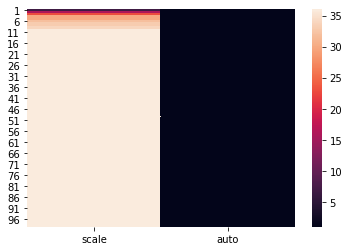

In [64]:
ax = sns.heatmap(right_guess_df)

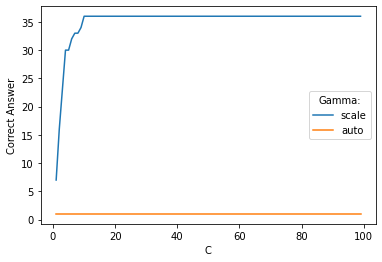

In [109]:
fig, ax = plt.subplots()
ax.plot(c_vals, right_guess_df['scale'].values, label='scale')
ax.plot(c_vals, right_guess_df['auto'].values, label='auto')
plt.xlabel('C')
plt.ylabel('Correct Answer')
plt.legend(title='Gamma:')
plt.show()

In [105]:
max = np.argwhere(right_guess == top["scale"])
max[0]

array([9], dtype=int64)

In [68]:
from sklearn.model_selection import GridSearchCV

In [69]:
parameters = {'C': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'gamma': ['scale','auto']}
clf = svm.SVC()
grid_clf = GridSearchCV(clf, parameters)
grid_clf.fit(x_train,y_train.values.ravel())

C:\Users\asus\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(estimator=SVC(),
             param_grid={'C': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'gamma': ['scale', 'auto']})

In [73]:
print(grid_clf.best_params_)

{'C': 13, 'gamma': 'scale'}


In [77]:
grid_clf.best_params_['C']

13

In [78]:
grid_clf.best_params_['gamma']

'scale'

## Testing Phase

In [79]:
#find number of images in file
list = os.listdir(TEST_FOLDER) # dir is your directory path
number_files = len(list)
number_files

80

### Discrete Wavelet Transform

In [80]:
test_dwt= []

In [81]:
for iteration in range(number_files):
    i = iteration+1
    img = Image.open(f'{TEST_FOLDER}/{str(i)}.jpg')
    coeffs = pywt.wavedec2(img, wavelet = w, level = 2) 
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs) #arrange coeffs into single array
    features = coeff_arr[coeff_slices[0]]

    test_dwt.append(features)

### Discrete COsine Transform

In [82]:
test_dct_coeffs =[]

In [83]:
for i in range(80):
    coeff = dctn(test_dwt[i] , norm ='ortho')
    test_dct_coeffs.append(coeff)

In [84]:
test_coeffs_min = len(test_dct_coeffs[0])*len(test_dct_coeffs[0])
test_ind_coeffs_min = test_dct_coeffs[0]
for i in range(len(test_dct_coeffs)):
    if(len(test_dct_coeffs[i])*len(test_dct_coeffs[i][0])<test_coeffs_min):
        test_coeffs_min = len(test_dct_coeffs[i])*len(test_dct_coeffs[i][0])
        test_ind_coeffs_min = i

In [85]:
test_new_coeffs = []
if test_coeffs_min > coeffs_min:
    test_coeffs_min = coeffs_min

In [86]:
for n in range(number_files):
    height = len(test_dct_coeffs[n])
    width = len(test_dct_coeffs[n][0])
    row = []
    for k in range(width+height-1):
        for j in range(k+1):
            i = k-j
            if i<height and j<width:
                if len(row) < coeffs_min:
                    row.append(test_dct_coeffs[n][i][j])
    test_new_coeffs.append(row)

In [87]:
len(test_new_coeffs[0])

572

### SVM

Test data

In [88]:
x_test = test_new_coeffs
y_test = pd.read_csv(TEST_CSV, header=None)

In [89]:
final_classifier = svm.SVC(C = grid_clf.best_params_['C'],gamma = grid_clf.best_params_['gamma'])
final_classifier.fit(x_train,y_train.values.ravel())

SVC(C=13)

In [90]:
final_result = final_classifier.predict(x_test)
final_result

array([10, 16, 20, 14,  7, 10, 10,  4, 11, 13, 16, 10,  6, 10, 10,  2,  4,
        6,  6,  2,  2,  2, 10, 13, 10,  4, 10, 13, 10, 10, 16, 16,  2, 13,
       16,  5,  5,  5, 20,  2, 20,  2,  2,  2, 11, 13, 10, 19, 19, 19,  7,
        7, 14, 23, 14, 24, 10, 10, 10, 10, 12, 16, 22,  2,  7, 14, 14, 11,
        4, 24, 14,  2,  2, 24, 24,  2, 15, 14,  9, 21], dtype=int64)

In [91]:
final_cnt = 0
for i in range(len(y_test)):
    if(final_result[i]==y_test[0].values[i]):
        final_cnt = final_cnt+1
final_acc = final_cnt/len(y_test)
final_acc*100

45.0

In [120]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [118]:
accuracy_score(y_test, final_result)

0.45

In [121]:
precision_score(y_test, final_result, average=None)

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.23076923, 0.75      , 1.        , 1.        , 0.5       ,
       0.        , 0.        , 0.125     , 0.66666667, 1.        ,
       0.2       , 0.28571429, 1.        , 0.33333333, 0.        ,
       0.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.5       , 0.        ])